# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [2]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [3]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [5]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(58, 6)


,title,price,year,link,brand,age
0,2010 honda odessey,3000,2010.0,https://charlottesville.craigslist.org/cto/d/p...,honda,15.0
1,2008 kia sedona lx 4door,2500,2008.0,https://charlottesville.craigslist.org/cto/d/b...,kia,17.0
2,2012 jeep patriot 4x4,6250,2012.0,https://charlottesville.craigslist.org/cto/d/l...,jeep,13.0
3,"mitsubishi eclipse gt, 2008",6800,2008.0,https://charlottesville.craigslist.org/cto/d/c...,mitsubishi,17.0
4,2007 jeep wrangler - manual,8700,2007.0,https://charlottesville.craigslist.org/cto/d/c...,jeep,18.0


With the data in and wrangled, we can now do some analysis:

count       58.000000
mean      9897.396552
std      11029.248919
min        500.000000
25%       3837.500000
50%       6375.000000
75%      10887.500000
max      62800.000000
Name: price, dtype: float64


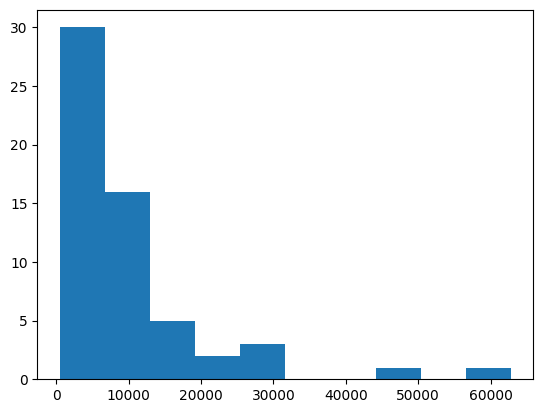

count    52.000000
mean     21.826923
std      15.281311
min       4.000000
25%      12.750000
50%      17.000000
75%      22.750000
max      68.000000
Name: age, dtype: float64


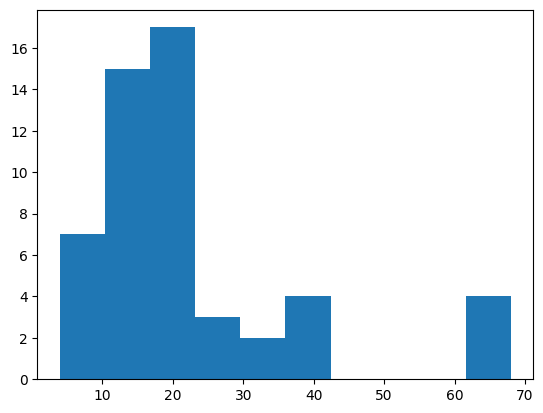

In [6]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [7]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                         \
           count          mean           std      min      25%      50%   
brand                                                                     
acura        1.0   7500.000000           NaN   7500.0   7500.0   7500.0   
audi         1.0  11000.000000           NaN  11000.0  11000.0  11000.0   
bmw          3.0   8500.000000   1322.875656   7500.0   7750.0   8000.0   
chevrolet    2.0  18500.000000   5656.854249  14500.0  16500.0  18500.0   
chevy        4.0   2675.000000   1584.034932    500.0   2300.0   2950.0   
dodge        1.0   4000.000000           NaN   4000.0   4000.0   4000.0   
ford         6.0  16333.333333  17078.251277   4000.0   6000.0  10500.0   
gmc          2.0  16500.000000  13435.028843   7000.0  11750.0  16500.0   
honda        8.0  10500.000000   8405.440415   3000.0   5600.0   7200.0   
jeep         3.0   8150.000000   1693.369422   6250.0   7475.0   8700.0   
kia          1.0   2500.000000           NaN   2500.0   2500.0   2500.0   
lexus        2.0  11175.000000    318.198052  10950.0  11062.5  11175.0   
mazda        1.0   3000.000000           NaN   3000.0   3000.0   3000.0   
missing     16.0   9396.812500  15168.907098   2250.0   3500.0   4150.0   
mitsubishi   1.0   6800.000000           NaN   6800.0   6800.0   6800.0   
subaru       1.0   3950.000000           NaN   3950.0   3950.0   3950.0   
tesla        1.0  26900.000000           NaN  26900.0  26900.0  26900.0   
toyota       3.0   6800.000000   3395.585369   4500.0   4850.0   5200.0   
volkswagen   1.0   2650.000000           NaN   2650.0   2650.0   2650.0   

                              
                75%      max  
brand                         
acura        7500.0   7500.0  
audi        11000.0  11000.0  
bmw          9000.0  10000.0  
chevrolet   20500.0  22500.0  
chevy        3325.0   4300.0  
dodge        4000.0   4000.0  
ford        16875.0  49500.0  
gmc         21250.0  26000.0  
honda       13250.0  29000.0  
jeep         9100.0   9500.0  
kia          2500.0   2500.0  
lexus       11287.5  11400.0  
mazda        3000.0   3000.0  
missing      5687.5  62800.0  
mitsubishi   6800.0   6800.0  
subaru       3950.0   3950.0  
tesla       26900.0  26900.0  
toyota       7950.0  10700.0  
volkswagen   2650.0   2650.0

In [8]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                     
           count       mean        std   min    25%   50%   75%   max
brand                                                                
acura        1.0  11.000000        NaN  11.0  11.00  11.0  11.0  11.0
audi         1.0   8.000000        NaN   8.0   8.00   8.0   8.0   8.0
bmw          3.0  15.666667   1.527525  14.0  15.00  16.0  16.5  17.0
chevrolet    2.0  52.000000  22.627417  36.0  44.00  52.0  60.0  68.0
chevy        3.0  31.333333  10.503968  21.0  26.00  31.0  36.5  42.0
dodge        1.0  22.000000        NaN  22.0  22.00  22.0  22.0  22.0
ford         6.0  16.333333   6.408328   8.0  11.50  17.5  22.0  22.0
gmc          1.0  41.000000        NaN  41.0  41.00  41.0  41.0  41.0
honda        8.0  12.125000   4.611709   4.0  10.25  12.5  15.0  19.0
jeep         3.0  14.333333   3.214550  12.0  12.50  13.0  15.5  18.0
kia          1.0  17.000000        NaN  17.0  17.00  17.0  17.0  17.0
lexus        2.0  17.000000   5.656854  13.0  15.00  17.0  19.0  21.0
mazda        1.0  17.000000        NaN  17.0  17.00  17.0  17.0  17.0
missing     13.0  30.230769  21.393745   7.0  13.00  25.0  36.0  68.0
mitsubishi   1.0  17.000000        NaN  17.0  17.00  17.0  17.0  17.0
subaru       0.0        NaN        NaN   NaN    NaN   NaN   NaN   NaN
tesla        1.0   7.000000        NaN   7.0   7.00   7.0   7.0   7.0
toyota       3.0  21.000000   4.000000  17.0  19.00  21.0  23.0  25.0
volkswagen   1.0  22.000000        NaN  22.0  22.00  22.0  22.0  22.0

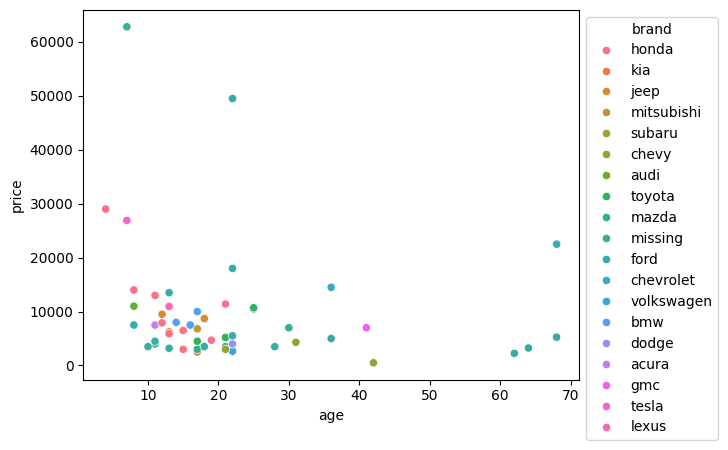

In [9]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   0.701792 -0.182665
log_age    -0.182665  0.365632
           log_price  log_age
log_price    1.00000 -0.36398
log_age     -0.36398  1.00000


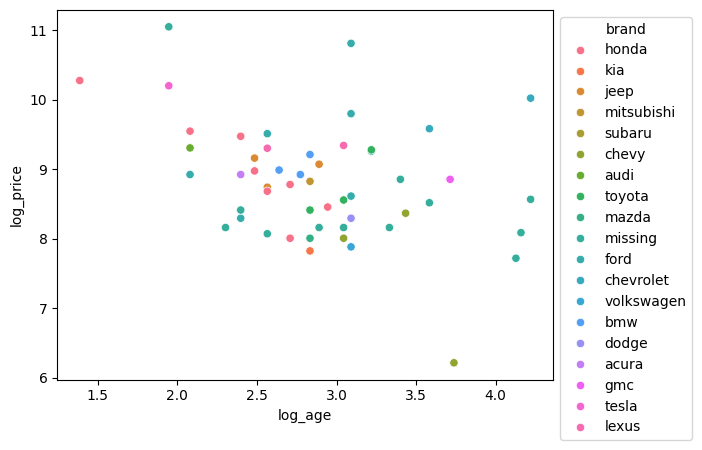

In [10]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab (completed code below):


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.

In [13]:
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
housing_url = 'https://charlottesville.craigslist.org/search/apa#search=1~gallery~0~0' # this is housing options on craiglist
housing_raw = requests.get(housing_url,headers=header)

In [14]:
housing_bsObj = soup(housing_raw.content,'html.parser')
housing_listings = housing_bsObj.find_all(class_="cl-static-search-result")

In [33]:
# data scraping:

housing_data = []

for listing in housing_listings:
    title = listing.find('div', class_='title')
    title_text = title.get_text().strip() if title else None  # this can identify missing entries

    price = listing.find('div', class_='price')
    price_text = price.get_text().strip() if price else None
    # this identifies missing price tags

    location = listing.find('div', class_='location')
    location_text = location.get_text().strip() if location else None

    housing_data.append({'title': title_text, 'price': price_text, 'location': location_text})

In [34]:
# data wrangling:

dt = pd.DataFrame.from_dict(housing_data)
dt['price'] = dt['price'].str.replace('$','')
dt['price'] = dt['price'].str.replace(',','')
dt['price'] = pd.to_numeric(dt['price'],errors='coerce') # coerces the price to be an integer
print(dt.shape)
dt.to_csv('./src/craigslist_housing.csv') # save data in case of a disaster
dt.head()

(106, 3)


,title,price,location
0,Two Bed/Two Bath Condo for Rent in Turtle Creek,1700,Charlottesville
1,"on the deck with a view, this mountain-side ha...",1270,None
2,One Bedroom private country setting,1200,Rural Earlysville
3,Used Manufactured home 28x52- HOME ONLY,750,"Charlottesville, VA"
4,1BR 1BA Within Walking Distance to Grounds!,1390,16th Street


count     106.000000
mean     1867.528302
std       896.295638
min        65.000000
25%      1360.000000
50%      1750.000000
75%      2120.000000
max      6500.000000
Name: price, dtype: float64


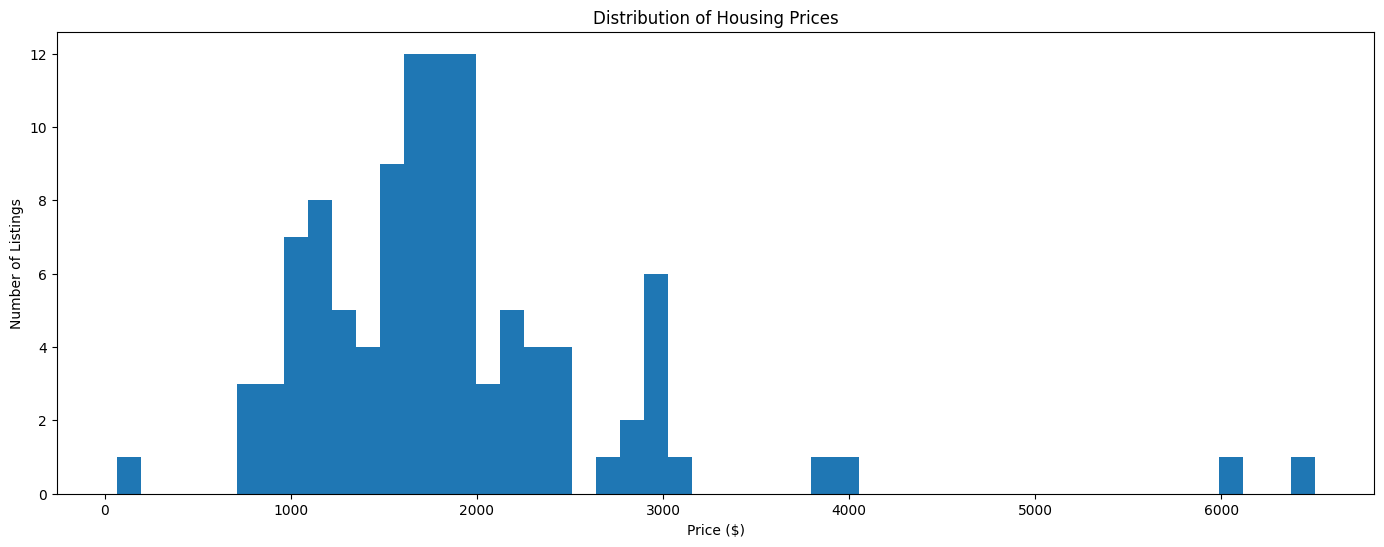

count                  88
unique                 41
top       Charlottesville
freq                   21
Name: location, dtype: object


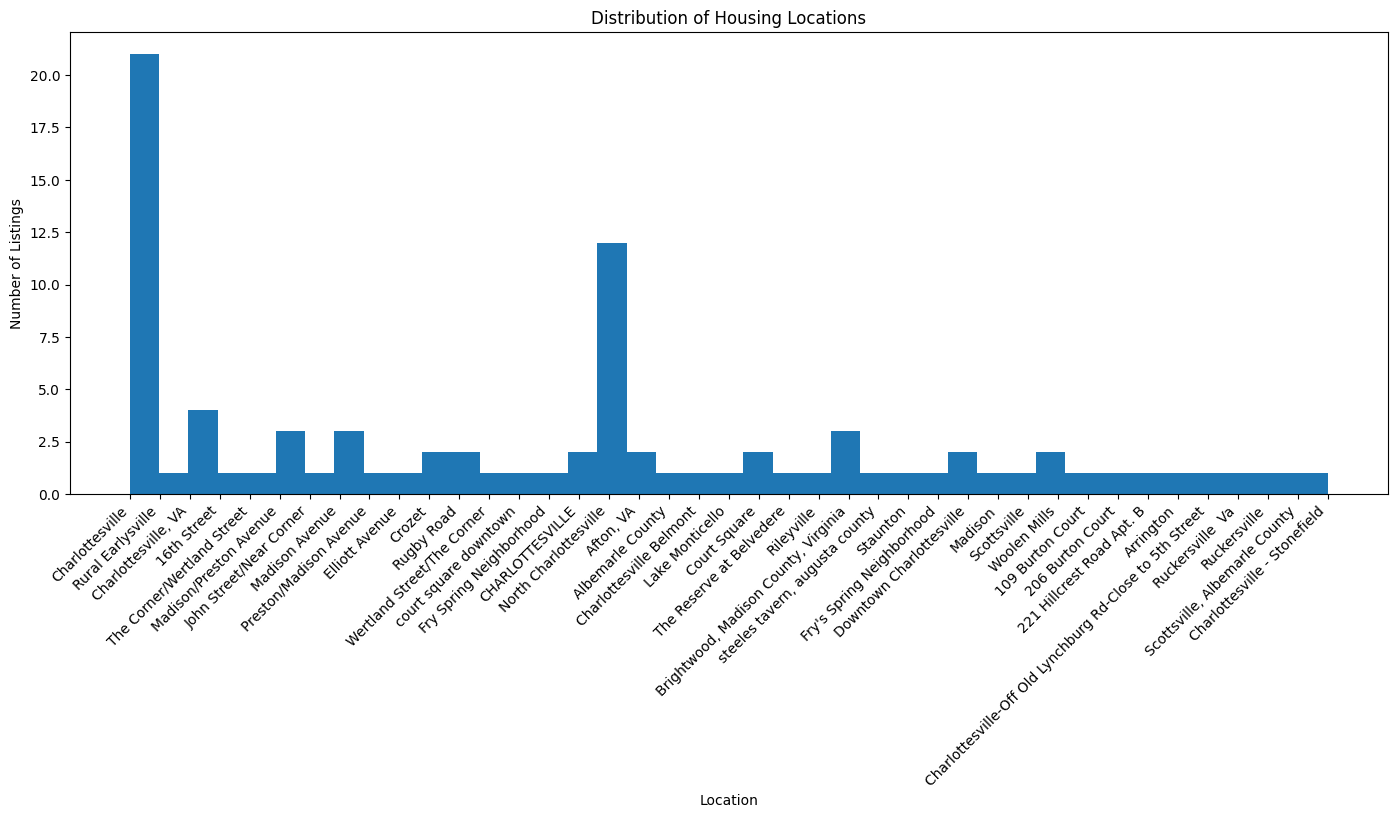

In [36]:
# plot analysis:

plt.figure(figsize=(17, 6))
print(dt['price'].describe())
dt['price'].hist(bins=50, grid=False)
plt.title("Distribution of Housing Prices")
plt.xlabel("Price ($)")
plt.ylabel("Number of Listings")
plt.show()

plt.figure(figsize=(17, 6))
print(dt['location'].describe())
dt['location'].hist(bins=41,grid=False)
plt.title("Distribution of Housing Locations")
plt.xlabel("Location")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Listings")
plt.show()

In [43]:
# price by location:
dt.loc[:,['price','location']].groupby('location').describe()

price               \
                                                   count         mean   
location                                                                
109 Burton Court                                     1.0  1699.000000   
16th Street                                          1.0  1390.000000   
206 Burton Court                                     1.0  1699.000000   
221 Hillcrest Road Apt. B                            1.0  1499.000000   
Afton, VA                                            2.0  1500.000000   
Albemarle County                                     1.0  1900.000000   
Arrington                                            1.0  1600.000000   
Brightwood, Madison County, Virginia                 3.0  2300.000000   
CHARLOTTESVILLE                                      2.0  1675.000000   
Charlottesville                                     21.0  1488.523810   
Charlottesville - Stonefield                         1.0  1750.000000   
Charlottesville Belmont                              1.0  1125.000000   
Charlottesville, VA                                  4.0  1324.500000   
Charlottesville-Off Old Lynchburg Rd-Close to 5...   1.0  1350.000000   
Court Square                                         2.0  2075.000000   
Crozet                                               2.0  1500.000000   
Downtown Charlottesville                             2.0  2325.000000   
Elliott Avenue                                       1.0  1880.000000   
Fry Spring Neighborhood                              1.0  2250.000000   
Fry's Spring Neighborhood                            1.0  1000.000000   
John Street/Near Corner                              1.0  1950.000000   
Lake Monticello                                      1.0  1950.000000   
Madison                                              1.0  3150.000000   
Madison Avenue                                       3.0  1778.333333   
Madison/Preston Avenue                               3.0  1725.000000   
North Charlottesville                               12.0  2229.166667   
Preston/Madison Avenue                               1.0  1800.000000   
Rileyville                                           1.0  1395.000000   
Ruckersville                                         1.0  1150.000000   
Ruckersville  Va                                     1.0  1150.000000   
Rugby Road                                           2.0  1349.500000   
Rural Earlysville                                    1.0  1200.000000   
Scottsville                                          1.0  1100.000000   
Scottsville, Albemarle County                        1.0  2200.000000   
Staunton                                             1.0   825.000000   
The Corner/Wertland Street                           1.0  4050.000000   
The Reserve at Belvedere                             1.0  2030.000000   
Wertland Street/The Corner                           1.0  3895.000000   
Woolen Mills                                         2.0  2087.500000   
court square downtown                                1.0  1700.000000   
steeles tavern, augusta county                       1.0  1400.000000   

                                                                         \
                                                            std     min   
location                                                                  
109 Burton Court                                            NaN  1699.0   
16th Street                                                 NaN  1390.0   
206 Burton Court                                            NaN  1699.0   
221 Hillcrest Road Apt. B                                   NaN  1499.0   
Afton, VA                                            494.974747  1150.0   
Albemarle County                                            NaN  1900.0   
Arrington                                                   NaN  1600.0   
Brightwood, Madison County, Virginia                   0.000000  2300.0   
CHARLOTTESVIL

Text(0.5, 1.0, 'Price by Location of Housing Listings')

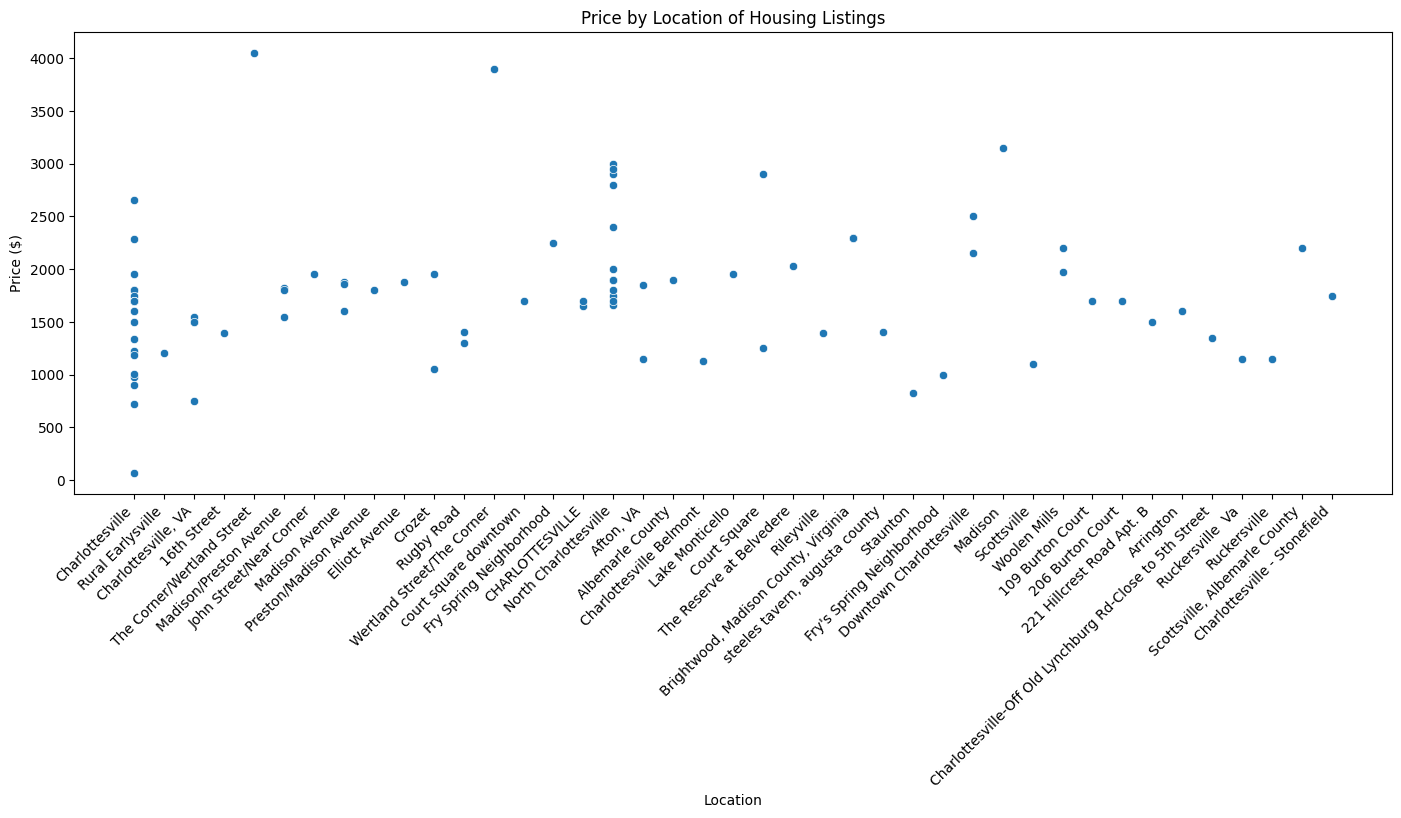

In [57]:
# scatterplot:

plt.figure(figsize=(17, 6))
plt.xticks(rotation=45, ha="right")
sns.scatterplot(data=dt, x='location', y='price')

plt.xlabel('Location')
plt.ylabel('Price ($)')
plt.title('Price by Location of Housing Listings')

^ This plot showed us that the most expensive housing options are all around The Corner/Wertland Street! This makes sense, because it is a highly sought after location for students to live in due to its close proximity to restaurants, bars, and parties.